# Cleaning data

In [1]:
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, re, os

def fillnan(df):
    columns = df.columns[df.isnull().any().tolist()]
    for col in columns:
        if df[col].dtype == 'object':
            df.loc[df[col].isnull(), col] = df[col].mode()
        else:
            df.loc[df[col].isnull(), col] = df[col].mean()
    return df

DATA_PATH = "data"
DATA_CLEANED_PATH = "data/cleaned_data"
SINGLE_FILE = False

In [18]:
col_acq = ['LoanID', 'Channel', 'SellerName', 'OrInterestRate', 'OrUnpaidPrinc', 'OrLoanTerm',
           'OrDate', 'FirstPayment', 'OrLTV', 'OrCLTV', 'NumBorrow', 'DTIRat', 'CreditScore',
           'FTHomeBuyer', 'LoanPurpose', 'PropertyType', 'NumUnits', 'OccStatus', 'PropertyState',
           'Zip', 'MortInsPerc', 'ProductType', 'CoCreditScore', 'Extra', 'MortInsType', 'RelMortInd'];
dtypesDict = OrderedDict([
    ("LoanID", "int64"),
    ("Channel", "category"),
    ("SellerName", "category"),
    ("OrInterestRate", "float64"),
    ("OrUnpaidPrinc", "int64"),
    ("OrLoanTerm", "int64"),
    ("OrDate", "str"),
    ("FirstPayment", "str"),
    ("OrLTV", "int64"),
    ("OrCLTV", "float64"),
    ("NumBorrow", "float64"),
    ("DTIRat", "float64"),
    ("CreditScore", "float64"),
    ("FTHomeBuyer", "category"),
    ("LoanPurpose", "category"),
    ("PropertyType", "category"),
    ("NumUnits", "int64"),
    ("OccStatus", "category"),
    ("PropertyState", "category"),
    ("Zip", "int64"),
    ("MortInsPerc", "float64"),
    ("ProductType", "category"),
    ("CoCreditScore", "float64"),
    ("Extra", "int64"),
    ("MortInsType", "category"),
    ("RelMortInd", "category"),
])

if SINGLE_FILE:
    df_acq = pd.read_csv('data/acq/Acquisition_2016Q4.txt', sep='|', names=col_acq, index_col=False) 
else:
    pattern = r'Acquisition_(20[0][7,8,9]|201[0,1,2])Q[1-4].txt'
    fpaths = sorted(filter(re.compile(pattern).match, os.listdir(f'data/acq')))
    df_acq = pd.concat([pd.read_csv(f'{DATA_PATH}/acq/{fp}', sep='|', names=col_acq, index_col=False) for fp in fpaths], axis=0).reset_index(drop=True)

In [19]:
col_per = ['LoanID', 'MonthRep', 'Servicer', 'CurrInterestRate', 'CAUPB', 'LoanAge', 'MonthsToMaturity',
           'AdMonthsToMaturity', 'MaturityDate', 'MSA', 'CLDS', 'ModFlag', 'ZeroBalCode', 'ZeroBalDate',
           'LastInstallDate', 'ForeclosureDate', 'DispositionDate', 'ForeclosureCosts', 'PPRC', 'AssetRecCost', 'MHRC',
           'ATFHP', 'NetSaleProceeds', 'CreditEnhProceeds', 'RPMWP', 'OFP', 'NIBUPB', 'PFUPB', 'RMWPF',
           'FPWA', 'ServicingIndicator']

if SINGLE_FILE:
    df_perf = pd.read_csv('data/perf/Performance_2016Q4.txt', sep='|', names=col_per, index_col=False) 
else:
    pattern = r'Performance_(201[0,1,2])Q[1-4].txt'
    fpaths = sorted(filter(re.compile(pattern).match, os.listdir(f'data/perf')))
    df_per = pd.concat([pd.read_csv(f"{DATA_PATH}/perf/{fp}", sep='|', names=col_per, usecols=[0, 10], dtype={'LoanID': int, 'CLDS': str}, index_col=False) for fp in fpaths], axis=0)

df_per = df_per.dropna(subset=['CLDS'])
df_per['CLDS'] = df_per['CLDS'].astype(str)

NUM_MONTHS = "4"
df_delinq4 = df_per.loc[df_per['CLDS'] == NUM_MONTHS]
df_delinq4.drop_duplicates(subset='LoanID', keep='last', inplace=True)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
df = pd.merge(df_acq, df_delinq4, on='LoanID', how='outer')

del df_acq, df_per, df_delinq4

df['Zip'] = df['Zip'].astype(str)
df = df.reset_index().rename(columns={'CLDS': 'Default'})
df.loc[df['Default'] == '4', 'Default'] = 1
df.loc[df['Default'].isnull(), 'Default'] = 0
df['Default'] = df['Default'].astype(int)

df.drop(['index','OrDate','OrLTV','MortInsPerc','RelMortInd','FirstPayment'], axis=1, inplace=True)
df = fillnan(df)

In [21]:
df['Channel'], Channel = df['Channel'].factorize()
df['SellerName'], SellerName = df['SellerName'].factorize()
df['FTHomeBuyer'], FTHomeBuyer = df['FTHomeBuyer'].factorize()
df['LoanPurpose'], LoanPurpose = df['LoanPurpose'].factorize()
df['PropertyType'], PropertyType = df['PropertyType'].factorize()
df['OccStatus'], OccStatus = df['OccStatus'].factorize()
df['PropertyState'], PropertyState = df['PropertyState'].factorize()
df['Zip'], Zip = df['Zip'].factorize()
df['ProductType'], ProductType = df['ProductType'].factorize()
df['MortInsType'], MortInsType = df['MortInsType'].factorize()

mappings = {
    'Channel': Channel.tolist(),
    'SellerName': SellerName.tolist(),
    'FTHomeBuyer': FTHomeBuyer.tolist(),
    'LoanPurpose': LoanPurpose.tolist(),
    'PropertyType': PropertyType.tolist(),
    'OccStatus': OccStatus.tolist(),
    'PropertyState': PropertyState.tolist(),
    'Zip': Zip.tolist(),
    'ProductType': ProductType.tolist(),
    'MortInsType': MortInsType.tolist(),
}

df.to_parquet(f'{DATA_CLEANED_PATH}/fnma_cleaned.pq')
with open(f'{DATA_CLEANED_PATH}/fnma_mappings.pkl', 'wb') as f:
    pickle.dump(mappings, f)

In [ ]:
df['Default'].value_counts()

In [ ]:
# plot
columns = ['OrInterestRate','OrCLTV','DTIRat','CreditScore','OrUnpaidPrinc']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8,7))
plt.tight_layout(w_pad=3.0, h_pad=3.0)

for i, column in zip(range(1, len(columns)+1), columns):
    plt.subplot(3, 3, i)
    sns.boxplot(x="Default", y=column, data=df, linewidth=0.5)
    plt.xlabel('Default')

# Model

In [174]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve, auc,
                             precision_score, recall_score, precision_recall_curve, f1_score, 
                             accuracy_score)
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt


In [189]:
df = pd.read_parquet(f'{DATA_CLEANED_PATH}/fnma_cleaned.pq').sample(10_000)

In [226]:
Xcolumns=['Channel','SellerName','OrInterestRate','OrUnpaidPrinc','OrLoanTerm','OrCLTV','NumBorrow','DTIRat','CreditScore','FTHomeBuyer','LoanPurpose','PropertyType','NumUnits','OccStatus','PropertyState','Zip','ProductType','CoCreditScore','Extra','MortInsType']
CONTINUOUS_COLUMNS = ['OrInterestRate', 'OrUnpaidPrinc', 'OrLoanTerm', 'OrCLTV', 'NumBorrow', 'DTIRat', 'CreditScore', 'NumUnits', 'CoCreditScore', 'Extra']
CATEGORICAL_COLUMNS = sorted([i for i in Xcolumns if i not in CONTINUOUS_COLUMNS])
LABEL_COLUMNS = ['Default']

In [227]:
y = df['Default']#.values
X = df.drop(['Default','LoanID'], axis=1)#.values
# Xcolumns = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y, shuffle=True)
X_train = X_train[CATEGORICAL_COLUMNS + CONTINUOUS_COLUMNS]
X_test = X_test[CATEGORICAL_COLUMNS + CONTINUOUS_COLUMNS]

In [228]:
print("Train ", X_train.shape, y_train.sum())
print("Test ", X_test.shape, y_test.sum())

scaling = (len(y_train)-y_train.sum())/y_train.sum()
scaling = float(scaling)

print('scaling:', scaling )

Train  (7000, 20) 29
Test  (3000, 20) 12
scaling: 240.3793103448276


In [231]:
params = {
    # 'num_rounds':        100,
    # 'max_depth':         12,
    # 'max_leaves':        0,
    # 'alpha':             3,
    # 'lambda':            1,
    # 'eta':               0.17,
    # 'subsample':         1,
    # 'sampling_method':   'uniform', # uniform
    # 'scale_pos_weight':  scaling,
    # 'max_delta_step':    1,
    # 'max_bin':           64,
    # 'tree_method':       'hist',
    # 'grow_policy':       'lossguide',
    # # 'n_gpus':            1,
    # 'objective':         'binary:logistic',#'binary:hinge'
    # 'eval_metric':       'aucpr',#'error',#'auc', 'logloss'
    # 'predictor':         'cpu_predictor',
    # 'num_parallel_tree': 1,
    # "min_child_weight":  2,
    'verbose':           True
}


In [238]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)    
evals = [(dtest, 'test'), (dtrain, 'train')]

model = xgb.train(params, dtrain, 500, evals=evals, early_stopping_rounds=10)
model.save_model(f'{DATA_CLEANED_PATH}/xgb_model')

[22:58:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	test-rmse:0.35004	train-rmse:0.35004
[1]	test-rmse:0.24506	train-rmse:0.24506
[2]	test-rmse:0.17156	train-rmse:0.17156
[3]	test-rmse:0.12011	train-rmse:0.12011
[4]	test-rmse:0.08409	train-rmse:0.08409
[5]	test-rmse:0.05887	train-rmse:0.05887
[6]	test-rmse:0.04121	train-rmse:0.04121
[7]	test-rmse:0.02885	train-rmse:0.02885
[8]	test-rmse:0.02020	train-rmse:0.02020
[9]	test-rmse:0.01414	train-rmse:0.01414
[10]	test-rmse:0.00990	train-rmse:0.00990
[11]	test-rmse:0.00693	train-rmse:0.00693
[12]	test-rmse:0.00485	train-rmse:0.00485
[13]	test-rmse:0.00340	train-rmse:0.00340
[14]	t

In [235]:
use_f1_measure = True

preds = model.predict(dtest)
    
true_labels = y_test.astype(int).values.squeeze()
precision, recall, thresholds = precision_recall_curve(true_labels, preds)

if use_f1_measure:
    # apply the threshold using F1 measure to the prediction.
    threshold_idx = np.argmax((2 * precision * recall)/ (precision + recall+1e-7))
    pred_labels = (preds >= thresholds[threshold_idx]).astype(int)
else:
    # apply the threshold TPR-FPR to the prediction.
    fpr, tpr, thresholds = roc_curve(true_labels, preds)
    threshold_idx = np.argmax(tpr - fpr)
    pred_labels = (preds >= thresholds[threshold_idx]).astype(int)
    print(f'TPR: {tpr[threshold_idx]: 0.4f}')
    print(f'FPR: {fpr[threshold_idx]: 0.4f}')
    
    
print(f'Threshold: {thresholds[threshold_idx]: 0.4f}')
print(f'Precision: {precision[threshold_idx]: 0.4f}')
print(f'Recall: {recall[threshold_idx]: 0.4f}')
print('Predicted', pred_labels.sum())
print('Actual', true_labels.sum())
# compute the auc, this should match the last test auc output above
#
auc_measure = roc_auc_score(true_labels, preds)

print(f'AUC {auc_measure: 0.4f}')

print (f'Accuracy: {accuracy_score(true_labels, pred_labels): 0.4f}')

print (f'F1: {(2 * precision[threshold_idx] * recall[threshold_idx]) / (precision[threshold_idx] + recall[threshold_idx]): 0.4f}')
recall = recall
precision = precision
# area under precision recall curve
auprc= auc(recall, precision)
print(f'AUPRC: {auprc: 0.4f}')

Threshold:  0.9998
Precision:  1.0000
Recall:  1.0000
Predicted 12
Actual 12
AUC  1.0000
Accuracy:  1.0000
F1:  1.0000
AUPRC:  1.0000


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

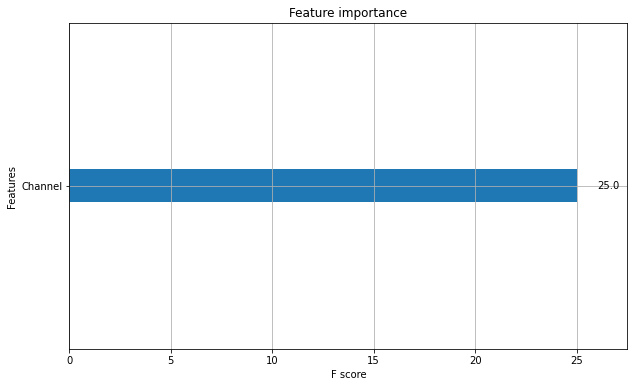

In [246]:
x = plt.rcParams["figure.figsize"] = [10,6]
fig, ax = plt.subplots()
xgb.plot_importance(model, ax = ax)

In [193]:
# Function for plotting Precision Recall curve and measuring AUC
def plot_precision_recall(y_test: np.array, y_score: np.array, isPR = True) -> None:
    #print(y_test[0:20],y_score[0:20])
    precision, recall, _ = precision_recall_curve(y_test, y_score) if isPR else roc_curve(y_test, y_score)
    auc_score = auc(recall, precision)
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('Precision-Recall curve: AUC={0:0.4f}'.format(auc_score))
    plt.show()

plt.rcParams["figure.figsize"] = [10,6]
plot_precision_recall(y_test.values, preds)

NameError: name 'preds' is not defined

In [ ]:
import shap

In [ ]:
expl = shap.TreeExplainer(model)
shap_values = expl.shap_values(X_test)

print(shap_values.shape)
print(f'XGBoost version: {xgb.__version__}')


In [ ]:
np.save(f'{DATA_CLEANED_PATH}/xgb_shap.npy', shap_values)

In [ ]:
# save for dashboarding
X_train.to_parquet(f'{DATA_CLEANED_PATH}/xgb_xtrain.parquet')
y_train.to_frame().to_parquet(f'{DATA_CLEANED_PATH}/xgb_ytrain.parquet')

X_test.to_parquet(f'{DATA_CLEANED_PATH}/xgb_xtest.parquet')
y_test.to_frame().to_parquet(f'{DATA_CLEANED_PATH}/xgb_ytest.parquet')

# Clustering

In [ ]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import umap.umap_ as umap

In [ ]:
df_shap = np.load(f'{DATA_CLEANED_PATH}/xgb_shap.npy')

In [ ]:
y_test = pd.read_parquet(f'{DATA_CLEANED_PATH}/xgb_ytest.parquet')

In [ ]:
nn_csr = nearest_neighbors.kneighbors_graph(df_shap, n_neighbors=n_neighbors)

In [ ]:
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2)

embedding = reducer.fit_transform(nn_csr)

In [ ]:
y_test = y_test.reset_index()
embedding = pd.DataFrame(embedding)
embedding = embedding.rename(columns={0: 'x', 1: 'y'})
embedding['partition'] = leiden_parts['partition']
embedding['Default'] = y_test['Default']
embedding.head()

In [ ]:
df_shap

# test

In [26]:
import pandas as pd
import plotly.express as px
import numpy as np 
import plotly.graph_objects as go

df = pd.read_parquet("data/embedding.parquet")
df = df.head(1000)

df_og = pd.read_parquet(f"{DATA_CLEANED_PATH}/fnma_cleaned.pq").head(1000)

In [4]:
import shap
import xgboost as xgb


In [7]:
model = xgb.Booster()
model.load_model("data/xgb_model")

[23:55:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:854: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


In [10]:
X = df.drop(['partition', "x", "y"], axis=1)

explainer = shap.Explainer(model, X)

,Default,Channel,FTHomeBuyer,LoanPurpose,MortInsType,OccStatus,ProductType,PropertyState,PropertyType,SellerName,...,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrCLTV,NumBorrow,DTIRat,CreditScore,NumUnits,CoCreditScore,Extra
0,0,-0.119153,0.004591,0.168453,0.002885,-0.419985,0.0,-0.028478,0.069826,-0.061341,...,-1.954212,0.507595,-0.226524,-0.172569,0.278609,-0.046829,0.641295,-0.041540,0.193575,-0.003913
1,0,0.001039,0.026720,0.005115,0.002943,0.018441,0.0,-0.460594,0.039561,-0.048898,...,-1.085768,-0.133236,-0.626069,0.501857,0.280226,0.002552,-0.373302,-0.005998,0.110213,0.198788
2,0,-0.021705,-0.004434,-0.344546,0.003205,-0.368221,0.0,-0.119603,-0.165808,-0.127606,...,-1.923120,0.012259,-0.321613,-0.183801,-0.284781,0.175307,0.034724,-0.004786,-0.194489,-0.011734
3,0,0.012986,0.020631,0.060303,0.002135,0.021979,0.0,-0.009403,-0.161164,-0.223066,...,-2.140421,-0.149941,-0.463482,0.586665,-0.231165,0.651065,-0.527267,-0.001797,-0.639153,-0.041841
4,0,-0.041657,0.000483,-0.045917,0.002499,0.019476,0.0,-0.067070,0.050661,-0.033902,...,-1.483102,-0.308809,-0.392196,-0.632036,-0.190656,-0.026829,1.532354,-0.003798,0.293270,-0.026085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,-0.006297,0.016887,0.103933,0.000710,0.009255,0.0,-0.024371,0.019585,-0.089336,...,-2.478395,-0.274510,0.115824,0.645503,-0.202406,-0.651632,-0.785811,-0.002829,-0.872275,0.099006
996,0,0.051950,0.003415,-0.476887,0.003114,-0.272436,0.0,-0.052852,0.046089,-0.036512,...,-0.631392,0.032275,0.096900,-0.016466,-0.296902,-0.359756,-0.747793,-0.011625,-0.694957,-0.031113
997,0,-0.043775,0.009288,0.085883,0.002607,0.024718,0.0,0.256533,0.031851,0.018764,...,-2.032860,-0.074895,0.127281,0.285307,0.193663,-0.425717,-1.017227,-0.003026,0.153598,-0.057366
998,0,-0.066146,0.044840,0.087748,0.000398,0.016942,0.0,-0.444839,0.011306,-0.057356,...,-1.706185,-0.056561,-0.544394,0.666548,-0.239314,-0.147339,-0.863054,-0.001957,-1.223641,0.139535


In [249]:
explainer.expected_value

6.871917217227011e-07

In [254]:
shap_values = explainer(X)

 92%|==================  | 9233/10000 [00:12<00:00]       

In [257]:
shap_values[0]

.values =
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

.base_values =
6.871917217227011e-07

.data =
array([1.00000000e+00, 7.00000000e+00, 4.87500000e+00, 4.09000000e+05,
       3.60000000e+02, 7.50000000e+01, 1.00000000e+00, 1.80000000e+01,
       7.40000000e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 6.80000000e+02,
       0.00000000e+00, 7.66868035e+02, 1.07755474e+00, 0.00000000e+00])

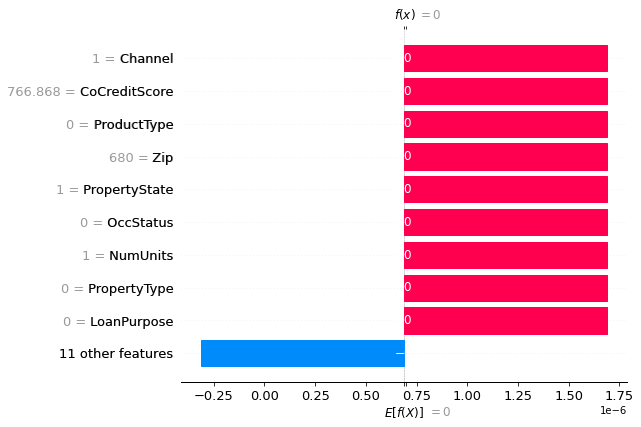

In [255]:
shap.plots.waterfall(shap_values[0])

In [36]:
data = df.drop(['partition', "x", "y"], axis=1)
shap.initjs()
shap.force_plot(6.871917217227011e-07, data.values[0,:], data.iloc[0,:])

In [38]:
plt.savefig('data/shap_force_plot.png')

AttributeError: 'AdditiveForceVisualizer' object has no attribute 'savefig'

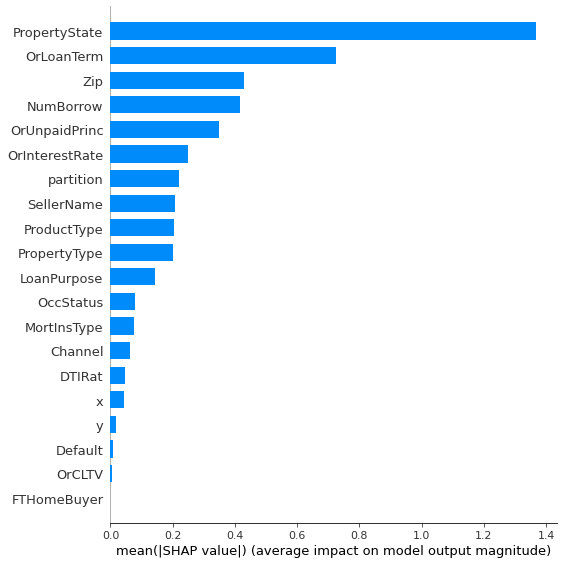

In [51]:
def feature_importance_plot(data):
    shap_values = data.loc[:, ~data.columns.isin(["x", "y", "partition", "Default"])].values
    return shap.summary_plot(shap_values, plot_type="bar", feature_names=data.columns)

feature_importance_plot(df)



In [ ]:
"Channel", "NumBorrow", "FTHomeBuyer", "LoanPurpose", "PropertyType", "NumUnits", "OccStatus", "ProductType", "Extra", "MortInsType", "Default"

In [70]:
df_og.nunique(axis=0)

LoanID            100000
Channel                3
SellerName            15
OrInterestRate       236
OrUnpaidPrinc        555
OrLoanTerm           105
OrCLTV               108
NumBorrow              5
DTIRat                65
CreditScore          357
FTHomeBuyer            3
LoanPurpose            3
PropertyType           5
NumUnits               4
OccStatus              3
PropertyState         54
Zip                  888
ProductType            1
CoCreditScore        319
Extra                  3
MortInsType            2
Default                1
dtype: int64

In [64]:
df.iloc[3, ~df.columns.isin(["x", "y", "partition", "Default"])].sum()

-3.3544118640000002

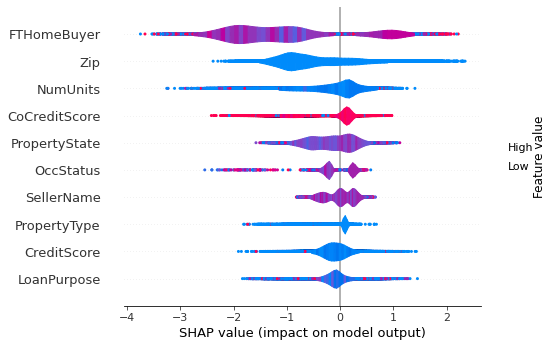

In [52]:
shap_og_values = df_og.loc[:, ~df_og.columns.isin(["x", "y", "partition", "Default", "LoanID"])].values
shap_values = df.loc[:, ~df.columns.isin(["x", "y", "partition", "Default"])].values

shap.summary_plot(shap_values, shap_og_values, plot_type="violin", max_display=10, feature_names=df_og.columns)

In [14]:
shap.plots.waterfall(shap_values[0])

AttributeError: 'numpy.ndarray' object has no attribute 'base_values'

In [81]:
df["partition"].value_counts()

1     237
9     198
8     141
0      97
4      96
10     53
7      52
2      47
3      42
6      33
5       4
Name: partition, dtype: int64

,x,y,partition,Default,Channel,FTHomeBuyer,LoanPurpose,MortInsType,OccStatus,ProductType,...,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrCLTV,NumBorrow,DTIRat,CreditScore,NumUnits,CoCreditScore,Extra
499,1.760201,10.240103,0,0,-0.016117,0.006909,0.057199,0.003111,0.015376,0.0,...,-1.351911,-0.283946,0.092880,-0.382545,-0.305541,-0.744220,0.492833,-0.002139,0.344417,-0.028814
732,2.712257,10.459385,0,0,-0.016723,0.008263,0.260057,0.003607,0.036824,0.0,...,-0.843078,0.127075,0.080954,-0.258724,-0.365129,0.283399,-0.687398,-0.002225,-0.018698,-0.037263
737,2.316555,9.276138,0,0,-0.001393,0.005769,-0.195377,0.004334,0.029836,0.0,...,-1.662891,-0.503591,0.137438,-0.871916,-0.192520,0.397343,-0.317371,0.000184,0.117291,-0.042815
741,2.222710,9.284309,0,0,0.009117,-0.005190,0.214918,0.002484,0.032543,0.0,...,-1.884747,0.087724,0.075245,-0.936403,-0.345761,-0.048887,-0.476617,0.000363,0.038814,-0.021179
205,2.783463,10.034613,0,0,-0.047622,0.023068,0.078009,0.003382,0.046822,0.0,...,-1.702692,-0.030139,0.077788,0.485937,-0.153793,0.206680,0.350107,0.000388,-0.047018,-0.045332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,-8.732227,-7.841568,10,0,-0.041369,0.008136,0.285336,0.002255,0.061442,0.0,...,0.681041,0.125128,-0.622643,-0.380193,-0.328387,-0.469556,-1.258327,-0.003839,0.093257,-0.007177
389,-8.194019,-7.628601,10,0,-0.163232,0.030450,0.384763,0.002787,0.040587,0.0,...,0.912570,-0.045308,-0.952632,0.202909,-0.303313,-0.346474,-0.716128,-0.005597,-1.436976,-0.010522
388,-10.885996,-8.444832,10,0,0.003657,0.006807,0.204393,0.003984,0.011085,0.0,...,0.791819,-0.086040,0.086947,-0.085948,-0.109628,0.318044,0.799683,-0.004509,0.455804,-0.029076
642,-10.538792,-8.329027,10,0,0.123147,0.019129,0.201766,0.002211,0.015037,0.0,...,0.405379,-0.080102,0.078663,0.026413,-0.214377,-0.286989,0.857989,-0.004270,0.178894,-0.034097


In [108]:
df["partition"].nunique()

11

In [121]:
data

,partition,LoanID,Channel,SellerName,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrCLTV,NumBorrow,DTIRat,...,PropertyType,NumUnits,OccStatus,PropertyState,Zip,ProductType,CoCreditScore,Extra,MortInsType,Default
0,0,9890664965089,67,419,602.625,17885000.0,31140.0,6671.0,148.0,4000.350972,...,35,100.0,12,1848,19148,0,72987.873863,104.437044,0,0
1,1,24152908668802,188,1001,1470.345,43934000.0,78072.0,16923.0,360.0,8637.579374,...,100,249.0,46,4947,41166,0,178777.865003,255.364051,0,0
2,2,4789731327286,32,208,292.500,9532000.0,15823.0,3327.0,71.0,1987.350972,...,24,49.0,8,718,8472,0,35246.304966,51.257299,0,0
3,3,4280745678309,29,178,263.145,8611000.0,13740.0,2819.0,60.0,1596.526458,...,11,46.0,11,773,7594,0,31527.568897,45.947080,1,0
4,4,9785311484963,69,436,602.115,18115000.0,32284.0,6881.0,145.0,3721.175486,...,38,99.0,12,2002,17682,0,72095.741898,104.592153,0,0
5,5,405715303902,5,10,25.750,523000.0,1440.0,257.0,7.0,197.000000,...,0,4.0,0,107,566,0,2698.868035,4.232664,0,0
6,6,3357206674585,30,152,205.375,5839000.0,11100.0,2282.0,48.0,1209.175486,...,19,35.0,7,443,5597,0,24915.568897,35.481752,0,0
7,7,5286539625909,41,230,321.795,9998000.0,17400.0,3556.0,81.0,2039.000000,...,12,56.0,13,1133,8614,0,39157.909070,56.489963,0,0
8,8,14338611345999,104,577,875.270,27721000.0,46380.0,9798.0,223.0,5337.175486,...,50,148.0,21,2743,22058,0,105472.574726,151.771897,1,0
9,9,20181528791036,143,853,1229.194,38649000.0,65916.0,14413.0,299.0,7206.526458,...,69,201.0,39,3746,35004,0,150297.560037,214.261861,2,0


In [162]:
data = df.groupby("partition").mean().reset_index().drop(columns=["x", "y"]).sort_values(by="Default", ascending=False)
data["Default"] = (data["Default"].round(3) * 100).astype(str)  + '%'
data = data.round(2)
data

,partition,Default,Channel,FTHomeBuyer,LoanPurpose,MortInsType,OccStatus,ProductType,PropertyState,PropertyType,...,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrCLTV,NumBorrow,DTIRat,CreditScore,NumUnits,CoCreditScore,Extra
3,3,21.4%,0.01,0.01,0.20,0.00,-0.00,0.0,0.05,-0.01,...,0.88,-0.07,-0.03,-0.33,0.19,0.05,0.21,-0.0,0.09,-0.02
6,6,15.2%,0.01,-0.04,-0.41,0.00,-0.04,0.0,0.01,-0.01,...,0.82,-0.04,0.04,0.06,0.23,0.13,-0.22,-0.0,0.08,-0.00
10,10,11.3%,-0.01,0.01,0.16,0.00,-0.00,0.0,-0.13,-0.00,...,0.78,-0.07,-0.11,-0.29,-0.27,-0.07,-0.09,-0.0,-0.19,-0.03
0,0,3.1%,-0.02,0.00,-0.05,0.00,-0.03,0.0,-0.09,-0.00,...,-1.23,-0.16,0.08,-0.09,-0.29,-0.15,-0.11,-0.0,0.08,0.01
1,1,2.5%,-0.01,-0.01,-0.03,0.00,-0.01,0.0,-0.05,-0.02,...,-1.32,-0.07,0.08,-0.09,0.24,-0.10,-0.43,-0.0,0.15,-0.00
4,4,1.0%,-0.02,0.00,-0.01,0.00,-0.01,0.0,-0.06,-0.02,...,-1.72,0.03,-0.43,-0.36,0.25,-0.17,-0.73,-0.0,0.14,-0.02
9,9,0.5%,-0.02,0.00,-0.00,0.00,-0.03,0.0,-0.10,-0.03,...,-1.49,-0.21,0.10,-0.15,-0.22,-0.26,-0.70,-0.0,-0.88,-0.01
2,2,0.0%,-0.02,-0.02,-0.47,-0.03,-0.07,0.0,-0.10,-0.04,...,0.76,-0.04,0.00,-0.02,-0.31,-0.04,-0.64,-0.0,-0.24,0.00
5,5,0.0%,0.00,0.01,-0.29,-0.81,0.02,0.0,-0.06,-0.01,...,-1.61,-0.06,-0.12,0.57,0.14,-0.04,-0.80,-0.0,-0.04,0.21
7,7,0.0%,-0.03,0.01,0.04,0.00,-0.01,0.0,-0.11,-0.04,...,-1.75,-0.12,-0.43,-0.19,-0.30,-0.21,-0.07,-0.0,0.06,-0.02


In [164]:
df.groupby("partition").sum()["Default"]

partition
0     3
1     6
2     0
3     9
4     1
5     0
6     5
7     0
8     0
9     1
10    6
Name: Default, dtype: int64

<AxesSubplot:>

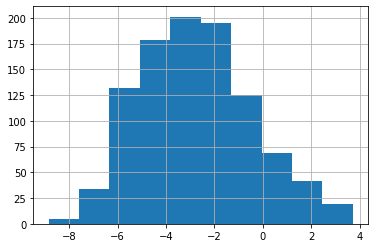

In [173]:
df.drop(columns=["x", "y", "partition", "Default"]).sum(axis=1).hist()

In [2]:
import random, json

In [21]:
with open('data/demo.json', 'r') as f:
    data = json.loads(f.read())
explanation = data['explanations'][random.randint(0, len(data['explanations']))]
# explanation

print(explanation["outValue"])
count = 0
for feature in explanation["features"]:
    count += explanation["features"][feature]["effect"]
print(count)

6.300001889162652
8.732669143535906


In [104]:
data['explanations'][:200]

[{'outValue': -5.273629097885442,
  'simIndex': 326.0,
  'features': {'0': {'effect': 0.49054848408047214, 'value': 39.0},
   '1': {'effect': -0.2753926566590231, 'value': ' State-gov'},
   '2': {'effect': 0.584700008724904, 'value': 13.0},
   '3': {'effect': -0.3170193278471125, 'value': ' Never-married'},
   '4': {'effect': -0.2564318273770638, 'value': ' Adm-clerical'},
   '5': {'effect': -0.7756616109203158, 'value': ' Not-in-family'},
   '6': {'effect': 0.03209947021991276, 'value': ' White'},
   '7': {'effect': 0.2754209317691883, 'value': ' Male'},
   '8': {'effect': -2.4662273739529748, 'value': 2174.0},
   '9': {'effect': -0.02499080658259028, 'value': 0.0},
   '10': {'effect': -0.12447308586845034, 'value': 40.0},
   '11': {'effect': 0.016465950900866774, 'value': ' United-States'}}},
 {'outValue': -0.5948121122444343,
  'simIndex': 489.0,
  'features': {'0': {'effect': 1.008950594057879, 'value': 50.0},
   '1': {'effect': -0.3299447299367165, 'value': ' Self-emp-not-inc'},
 

In [111]:
dat.sum()

1.7056488719999996

In [116]:

[{
    "outValue": row.sum(),
    "features": {i: {'effect' : dat_og[values_shap], 'value': row[values_og]} for i, (values_og, values_shap) in enumerate(zip(dat.keys(), dat_og.keys()))}
} for idx, row in dat_og.iterrows()
]

[{'outValue': 1.7056488719999996,
  'features': {0: {'effect': 0      0
    1      0
    2      1
    3      1
    4      1
          ..
    178    0
    179    0
    180    1
    181    1
    182    1
    Name: Channel, Length: 183, dtype: int64,
    'value': 0.0},
   1: {'effect': 0       0
    1       1
    2       2
    3       3
    4       4
           ..
    178     6
    179    13
    180    14
    181     5
    182     4
    Name: SellerName, Length: 183, dtype: int64,
    'value': 0.0},
   2: {'effect': 0      6.250
    1      6.000
    2      6.375
    3      6.125
    4      5.875
           ...  
    178    6.375
    179    6.375
    180    6.000
    181    5.875
    182    5.750
    Name: OrInterestRate, Length: 183, dtype: float64,
    'value': 0.0},
   3: {'effect': 0      137000.0
    1      116000.0
    2       58000.0
    3      353000.0
    4      385000.0
             ...   
    178    213000.0
    179    191000.0
    180    146000.0
    181    225000.0
    182    

In [114]:
dat_og = df_og.iloc[:183, ~df_og.columns.isin(["LoanID","Default"])]
for x, y in dat_og.iterrows():
    print(x)
    print(y)

0
Channel                0.000000
SellerName             0.000000
OrInterestRate         6.250000
OrUnpaidPrinc     137000.000000
OrLoanTerm           360.000000
OrCLTV                56.000000
NumBorrow              2.000000
DTIRat                37.000000
CreditScore          741.000000
FTHomeBuyer            0.000000
LoanPurpose            0.000000
PropertyType           0.000000
NumUnits               1.000000
OccStatus              0.000000
PropertyState          0.000000
Zip                    0.000000
ProductType            0.000000
CoCreditScore        734.000000
Extra                  1.077555
MortInsType            0.000000
Name: 0, dtype: float64
1
Channel                0.000000
SellerName             1.000000
OrInterestRate         6.000000
OrUnpaidPrinc     116000.000000
OrLoanTerm           360.000000
OrCLTV                80.000000
NumBorrow              2.000000
DTIRat                11.000000
CreditScore          796.000000
FTHomeBuyer            0.000000
LoanPurpose 

In [95]:
a = {0: {'effect': 0.012985561, 'value': 1}, 1: {'effect': 0.020631006, 'value': 3}, 2: {'effect': 0.060303316, 'value': 6.125}, 3: {'effect': 0.002135231, 'value': 353000.0}, 4: {'effect': 0.021978654, 'value': 360.0}, 5: {'effect': 0.0, 'value': 80.0}, 6: {'effect': -0.009402543, 'value': 2.0}, 7: {'effect': -0.161163867, 'value': 28.0}, 8: {'effect': -0.223065853, 'value': 778.0}, 9: {'effect': -0.121476024, 'value': 0}, 10: {'effect': -2.140420675, 'value': 1}, 11: {'effect': -0.149941429, 'value': 0}, 12: {'effect': -0.463482112, 'value': 1.0}, 13: {'effect': 0.586665452, 'value': 0}, 14: {'effect': -0.23116523, 'value': 3}, 15: {'effect': 0.651064515, 'value': 3}, 16: {'effect': -0.527266502, 'value': 0}, 17: {'effect': -0.001796969, 'value': 656.0}, 18: {'effect': -0.639152944, 'value': 1.0775547418592215}, 19: {'effect': -0.041841451, 'value': 0}}

a

{0: {'effect': 0.012985561, 'value': 1},
 1: {'effect': 0.020631006, 'value': 3},
 2: {'effect': 0.060303316, 'value': 6.125},
 3: {'effect': 0.002135231, 'value': 353000.0},
 4: {'effect': 0.021978654, 'value': 360.0},
 5: {'effect': 0.0, 'value': 80.0},
 6: {'effect': -0.009402543, 'value': 2.0},
 7: {'effect': -0.161163867, 'value': 28.0},
 8: {'effect': -0.223065853, 'value': 778.0},
 9: {'effect': -0.121476024, 'value': 0},
 10: {'effect': -2.140420675, 'value': 1},
 11: {'effect': -0.149941429, 'value': 0},
 12: {'effect': -0.463482112, 'value': 1.0},
 13: {'effect': 0.586665452, 'value': 0},
 14: {'effect': -0.23116523, 'value': 3},
 15: {'effect': 0.651064515, 'value': 3},
 16: {'effect': -0.527266502, 'value': 0},
 17: {'effect': -0.001796969, 'value': 656.0},
 18: {'effect': -0.639152944, 'value': 1.0775547418592215},
 19: {'effect': -0.041841451, 'value': 0}}

In [ ]:
-3 

5

In [101]:
dat

Channel           0.154235
FTHomeBuyer      -0.070299
LoanPurpose      -0.534840
MortInsType       0.003238
OccStatus         0.042022
ProductType       0.000000
PropertyState     0.160745
PropertyType      0.101377
SellerName        0.029198
Zip               0.568804
OrInterestRate    1.052178
OrUnpaidPrinc     0.000306
OrLoanTerm        0.061148
OrCLTV           -0.284870
NumBorrow         0.231924
DTIRat            0.266810
CreditScore      -0.093043
NumUnits         -0.003646
CoCreditScore     0.055457
Extra            -0.035094
Name: 183, dtype: float64

In [80]:
{i: {'effect' : dat[values_shap], 'value': dat_og[values_og]} for i, (values_og, values_shap) in enumerate(zip(dat_og.keys(), dat.keys()))}

{0: {'effect': 0.154234633, 'value': 2.0},
 1: {'effect': -0.070299357, 'value': 1.0},
 2: {'effect': -0.534840286, 'value': 5.75},
 3: {'effect': 0.00323768, 'value': 197000.0},
 4: {'effect': 0.042022139, 'value': 360.0},
 5: {'effect': 0.0, 'value': 28.0},
 6: {'effect': 0.160744995, 'value': 1.0},
 7: {'effect': 0.101376519, 'value': 58.0},
 8: {'effect': 0.0291976, 'value': 802.0},
 9: {'effect': 0.568804443, 'value': 0.0},
 10: {'effect': 1.052177787, 'value': 1.0},
 11: {'effect': 0.000306031, 'value': 2.0},
 12: {'effect': 0.061147593, 'value': 1.0},
 13: {'effect': -0.284869939, 'value': 1.0},
 14: {'effect': 0.231923908, 'value': 10.0},
 15: {'effect': 0.266809821, 'value': 151.0},
 16: {'effect': -0.093042545, 'value': 0.0},
 17: {'effect': -0.003645764, 'value': 766.8680345019693},
 18: {'effect': 0.055457175, 'value': 1.0775547418592215},
 19: {'effect': -0.035093561, 'value': 0.0}}

In [94]:
dat = df.iloc[183, ~df.columns.isin(["x", "y", "partition", "Default"])]
dat

Channel           0.154235
FTHomeBuyer      -0.070299
LoanPurpose      -0.534840
MortInsType       0.003238
OccStatus         0.042022
ProductType       0.000000
PropertyState     0.160745
PropertyType      0.101377
SellerName        0.029198
Zip               0.568804
OrInterestRate    1.052178
OrUnpaidPrinc     0.000306
OrLoanTerm        0.061148
OrCLTV           -0.284870
NumBorrow         0.231924
DTIRat            0.266810
CreditScore      -0.093043
NumUnits         -0.003646
CoCreditScore     0.055457
Extra            -0.035094
Name: 183, dtype: float64

In [42]:
data['featureNames']

{'0': 'Age',
 '1': 'Workclass',
 '2': 'Education-Num',
 '3': 'Marital Status',
 '4': 'Occupation',
 '5': 'Relationship',
 '6': 'Race',
 '7': 'Sex',
 '8': 'Capital Gain',
 '9': 'Capital Loss',
 '10': 'Hours per week',
 '11': 'Country'}

In [34]:
df[df["Default"] == 1]

,x,y,partition,Default,Channel,FTHomeBuyer,LoanPurpose,MortInsType,OccStatus,ProductType,...,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrCLTV,NumBorrow,DTIRat,CreditScore,NumUnits,CoCreditScore,Extra
49,-0.727379,-14.812649,6,1,-0.034666,-0.125433,-0.185611,0.002070,0.016110,0.0,...,0.274422,0.030729,0.120646,0.742258,0.197451,0.777920,-0.125135,-0.010623,0.060983,0.236453
79,-2.260662,-0.172825,1,1,0.133251,0.002794,-0.212975,0.005478,-0.443939,0.0,...,-2.250845,-0.210181,0.092817,-0.224069,0.330163,0.088055,0.199268,-0.003387,0.183044,-0.029345
141,-11.046551,-8.459259,10,1,0.003056,0.009405,0.172659,0.002450,0.009071,0.0,...,1.135396,-0.021091,0.102613,0.123803,-0.156486,0.285090,0.966577,-0.005316,0.047814,-0.020333
162,-5.577274,-13.808046,3,1,0.081264,0.000278,-0.068544,0.002199,-0.147131,0.0,...,1.367580,-0.131426,-0.221015,-0.519101,0.132896,0.157832,0.660741,-0.005595,0.097528,-0.010715
169,-3.233963,-2.267689,1,1,0.137000,0.003816,0.236509,0.003164,0.019397,0.0,...,-1.689669,-0.259836,0.088285,-0.535924,0.222713,-0.255292,1.489404,-0.001569,0.201343,-0.023794
179,-2.884003,-2.642673,1,1,-0.127513,0.017865,-0.283666,0.005692,0.031427,0.0,...,-0.625262,0.145553,0.083901,-0.831644,0.247186,0.279514,1.172896,-0.002924,0.117333,-0.020427
183,-1.379565,-14.461124,6,1,0.154235,-0.070299,-0.534840,0.003238,0.042022,0.0,...,1.052178,0.000306,0.061148,-0.284870,0.231924,0.266810,-0.093043,-0.003646,0.055457,-0.035094
240,-1.887343,-15.010036,6,1,0.140792,-0.088156,-0.335240,0.003382,-0.003571,0.0,...,0.971403,-0.078586,0.057504,0.012770,0.302625,-0.399568,0.745229,0.172694,0.078092,-0.010163
349,-5.523178,-14.046604,3,1,0.036414,0.013776,0.218924,0.002757,0.030661,0.0,...,0.817501,-0.110177,0.062464,-0.504130,0.168256,-0.008478,0.722432,-0.002946,0.096612,-0.021459
442,-6.502197,-12.094467,3,1,0.075953,0.032533,0.093772,0.003080,-0.053690,0.0,...,1.590869,-0.113577,0.070623,0.904497,0.249702,0.161724,-0.926487,-0.012813,0.074790,0.091171


In [64]:
import pandas as pd

df = pd.read_parquet("data/cleaned_data/fnma_cleaned.pq").head(10_000)
df = df.loc[:, ~df.columns.isin(["x", "y", "partition"])]


df_em = pd.read_parquet("data/embedding.parquet").head(10_000).sort_values("partition")
df_em = df_em.loc[:, ~df_em.columns.isin(["x", "y", "partition", "Default", "LoanID"])]

In [70]:
df = pd.read_parquet("data/embedding.parquet").head(10_000).sort_values("partition")
df_values = pd.read_parquet("data/cleaned_data/fnma_cleaned.pq").head(10_000)
df["partition"] = df["partition"].astype(str)
df_values["partition"] = df["partition"]
df_values["Default"] = df["Default"]
df["LoanID"] = df_values["LoanID"]

In [104]:
df.iloc[0, :].drop(["x", "y", "partition", "Default", "LoanID"])

Channel           -0.00252
FTHomeBuyer       0.021786
LoanPurpose       0.123979
MortInsType       0.003029
OccStatus         0.017685
ProductType            0.0
PropertyState     0.053055
PropertyType      0.059201
SellerName        0.068413
Zip              -0.011028
OrInterestRate   -1.040179
OrUnpaidPrinc    -0.092309
OrLoanTerm        0.096862
OrCLTV            0.164403
NumBorrow        -0.297696
DTIRat             -0.3619
CreditScore      -0.025972
NumUnits         -0.002487
CoCreditScore    -0.049284
Extra            -0.030306
Name: 6175, dtype: object

In [83]:
df_selcted = df[df["LoanID"] == 121878039841]

df_selcted[df_selcted.columns.difference(["x", "y", "partition", "Default", "LoanID"])]


,Channel,CoCreditScore,CreditScore,DTIRat,Extra,FTHomeBuyer,LoanPurpose,MortInsType,NumBorrow,NumUnits,OccStatus,OrCLTV,OrInterestRate,OrLoanTerm,OrUnpaidPrinc,ProductType,PropertyState,PropertyType,SellerName,Zip
6175,-0.00252,-0.049284,-0.025972,-0.3619,-0.030306,0.021786,0.123979,0.003029,-0.297696,-0.002487,0.017685,0.164403,-1.040179,0.096862,-0.092309,0.0,0.053055,0.059201,0.068413,-0.011028


In [123]:
target_value = -8.5
indexes = df_em.sum(axis=1).sort_values()

indexes = indexes[(indexes > target_value - 1) & (indexes < target_value + 1)].index

df_graph = df_values.iloc[indexes]

In [128]:
df_graph.columns

Index(['LoanID', 'Channel', 'SellerName', 'OrInterestRate', 'OrUnpaidPrinc',
       'OrLoanTerm', 'OrCLTV', 'NumBorrow', 'DTIRat', 'CreditScore',
       'FTHomeBuyer', 'LoanPurpose', 'PropertyType', 'NumUnits', 'OccStatus',
       'PropertyState', 'Zip', 'ProductType', 'CoCreditScore', 'Extra',
       'MortInsType', 'Default', 'partition'],
      dtype='object')

In [161]:
df_graph.groupby("partition").mean()

,LoanID,Channel,SellerName,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrCLTV,NumBorrow,DTIRat,CreditScore,...,PropertyType,NumUnits,OccStatus,PropertyState,Zip,ProductType,CoCreditScore,Extra,MortInsType,Default
partition,,,,,,,,,,,,,,,,,,,,,
0,1.044152e+11,1.000000,3.000000,6.375000,94000.000000,360.0,34.000000,1.000000,39.000000,805.000000,...,0.000000,1.000000,0.00,10.000000,181.000000,0.0,766.868035,1.077555,0.0,0.0
2,1.205075e+11,1.333333,5.333333,5.916667,121000.000000,360.0,86.666667,1.333333,35.000000,736.666667,...,0.000000,1.000000,0.00,23.666667,486.666667,0.0,766.868035,1.077555,0.0,0.0
4,1.114767e+11,1.000000,6.000000,6.812500,292000.000000,360.0,60.000000,1.500000,34.500000,693.500000,...,0.500000,1.000000,0.00,31.000000,277.500000,0.0,727.934017,1.077555,0.0,0.0
5,1.132559e+11,0.666667,5.666667,6.625000,121000.000000,360.0,79.333333,1.333333,28.666667,751.000000,...,1.000000,1.000000,0.00,19.666667,266.333333,0.0,777.578690,1.051703,0.0,0.0
8,1.152634e+11,0.666667,4.666667,6.183750,173972.222222,330.0,68.444444,1.527778,35.027778,716.638889,...,0.277778,1.111111,0.25,17.638889,248.222222,0.0,762.991691,1.068938,0.0,0.0
9,1.169457e+11,0.666667,6.666667,6.229167,187500.000000,360.0,74.833333,1.500000,34.500000,726.833333,...,0.166667,1.000000,0.00,14.666667,278.666667,0.0,737.434017,1.077555,0.0,0.0


In [159]:
a = df_graph.groupby("partition").mean()[["NumBorrow", "CreditScore", "OrInterestRate"]].reset_index()
a["Default"] = df_graph.groupby("partition").count()[["Default"]].values
a

,partition,NumBorrow,CreditScore,OrInterestRate,Default
0,0,1.000000,805.000000,6.375000,1
1,2,1.333333,736.666667,5.916667,3
2,4,1.500000,693.500000,6.812500,2
3,5,1.333333,751.000000,6.625000,3
4,8,1.527778,716.638889,6.183750,36
5,9,1.500000,726.833333,6.229167,6


In [163]:
round(a,2)

,partition,NumBorrow,CreditScore,OrInterestRate,Default
0,0,1.00,805.00,6.38,1
1,2,1.33,736.67,5.92,3
2,4,1.50,693.50,6.81,2
3,5,1.33,751.00,6.62,3
4,8,1.53,716.64,6.18,36
5,9,1.50,726.83,6.23,6


In [146]:
fig = px.histogram(df_graph, x="partition", title="Similarity metric").update_xaxes(categoryorder="total ascending")
fig

In [2]:
import pandas as pd

df = pd.read_parquet("data/embedding.pq").head(10_000).sort_values("partition")
df_values = pd.read_parquet("data/fnma_cleaned.pq").head(10_000)
df["partition"] = df["partition"].astype(str)
df_values["partition"] = df["partition"]
df_values["Default"] = df["Default"]



In [7]:
default_indeces = pd.merge(df[df["Default"]==1], df_values, left_index=True, right_index=True)["LoanID"].sample(20).index

for idx in default_indeces:
    print(df_values.iloc[idx]["LoanID"])

104093916634
107026913172
121179158448
107996042551
130008433018
123919580202
110685259022
132046392741
128828811571
134267196955
127276609469
116423142839
112716068330
121073410881
133988681362
114214537799
129480941433
114072794603
115396332066
100688629398


In [6]:
df_values.iloc[8015]  # 124583703152

LoanID            128374874861
Channel                      1
SellerName                   1
OrInterestRate             6.5
OrUnpaidPrinc          71000.0
OrLoanTerm               360.0
OrCLTV                    95.0
NumBorrow                  1.0
DTIRat                    25.0
CreditScore              720.0
FTHomeBuyer                  0
LoanPurpose                  2
PropertyType                 2
NumUnits                   1.0
OccStatus                    0
PropertyState               25
Zip                        104
ProductType                  0
CoCreditScore       766.868035
Extra                      1.0
MortInsType                  0
Default                      1
partition                    1
Name: 8015, dtype: object

In [33]:
df_values.drop("LoanID", axis=1)

,Channel,SellerName,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrCLTV,NumBorrow,DTIRat,CreditScore,FTHomeBuyer,...,NumUnits,OccStatus,PropertyState,Zip,ProductType,CoCreditScore,Extra,MortInsType,Default,partition
0,0,0,6.250,137000.0,360.0,56.0,2.0,37.0,741.0,0,...,1.0,0,0,0,0,734.000000,1.077555,0,0,4
1,0,1,6.000,116000.0,360.0,80.0,2.0,11.0,796.0,0,...,1.0,1,1,1,0,762.000000,1.077555,0,0,4
2,1,2,6.375,58000.0,180.0,78.0,2.0,30.0,710.0,0,...,1.0,0,2,2,0,766.868035,1.077555,0,0,0
3,1,3,6.125,353000.0,360.0,80.0,2.0,28.0,778.0,0,...,1.0,0,3,3,0,656.000000,1.077555,0,0,8
4,1,4,5.875,385000.0,360.0,70.0,2.0,50.0,720.0,0,...,1.0,0,4,4,0,700.000000,1.077555,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,13,6.250,162000.0,360.0,60.0,1.0,50.0,695.0,0,...,1.0,0,23,39,0,766.868035,1.077555,0,0,9
9996,0,5,7.250,225000.0,360.0,75.0,1.0,50.0,613.0,0,...,1.0,0,27,71,0,766.868035,1.077555,0,0,8
9997,1,3,6.250,85000.0,360.0,87.0,1.0,48.0,671.0,0,...,1.0,0,20,575,0,766.868035,1.000000,0,0,1
9998,0,3,6.500,88000.0,180.0,77.0,1.0,25.0,641.0,0,...,1.0,0,9,809,0,766.868035,1.077555,0,0,9


In [52]:

import xgboost as xgb
import shap
import pandas as pd
import numpy as np

model = xgb.Booster()
model.load_model("data/cleaned_data/xgb_model")

data = [[0, 0.00000e+00, 9.00000e+00, 3.00000e+00, 2.69371e+05, 3.01000e+02, 4.50000e+01, 3.00000e+00, 3.00000e+00, 4.27000e+02, 0.00000e+00, 2.00000e+00, 4.00000e+00, 4.00000e+00, 2.00000e+00, 3.90000e+01, 5.54000e+02, 7.53720e+02, 1.67000e+00,1.00000e+00]]
data_pred = xgb.DMatrix(pd.DataFrame(data).values)
print(data_pred)
result = model.predict(data_pred)
print(result)

[6.7420547e-07]
